In [65]:
%load_ext autoreload
%autoreload 2
import os
import numpy as n
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10,6)
import pickle
import numpy.lib.recfunctions as rfn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
from modules import utils

### Load the data

In [19]:
data_file = 'data/all_data.p'

f = open(data_file, 'rb')
all_data = pickle.load(f)

In [20]:
experiment = all_data['Female1']

In [21]:
# Save timestamps into variable
ts = experiment['t']
# Save annotations into variable
annotations = experiment['ann']

## Calculate some features

In [31]:
vectors = {'rear_1' : ('ImplantedTailBase_1', 'BackCenter_1'),
           'rear_2' : ('InteracteeTailBase_2', 'BackCenter_2'),
           'front_1': ('BackCenter_1', 'NapeCenter_1'),
           'front_2': ('BackCenter_2', 'NapeCenter_2'),
           'head_1' : ('NapeCenter_1', ('GreenTape_1', 'RedTape_1')),
           'head_2' : ('NapeCenter_2', ('YellowEar_2', 'OrangeEar_2')),
           'front_1_to_front_2' : ('NapeCenter_1', 'NapeCenter_2'),
           'front_2_to_front_1' : ('NapeCenter_2', 'NapeCenter_1'),
           'front_1_to_rear_2' : ('NapeCenter_1', 'InteracteeTailBase_2'),
           'front_2_to_rear_1' : ('NapeCenter_2', 'ImplantedTailBase_1'),
           'rear_1_to_rear_2' : ('BackCenter_1','BackCenter_2'),
           'rear_2_to_rear_1' : ('BackCenter_2','BackCenter_1')}
velocities_to_calculate = [
    'BackCenter_1',
    'BackCenter_2',
]

In [32]:
exp = utils.compute_and_add_vectors(experiment,vectors)
exp = utils.compute_and_add_velocities(exp, velocities_to_calculate)

In [34]:
print(list(exp.dtype.fields.keys()))

['t', 'ann', 'GreenTape_1_y', 'GreenTape_1_x', 'RedTape_1_y', 'RedTape_1_x', 'ImplantedTailBase_1_y', 'ImplantedTailBase_1_x', 'YellowEar_2_y', 'YellowEar_2_x', 'OrangeEar_2_y', 'OrangeEar_2_x', 'InteracteeTailBase_2_y', 'InteracteeTailBase_2_x', 'Head_1_y', 'Head_1_x', 'NapeCenter_1_y', 'NapeCenter_1_x', 'NapeRight_1_y', 'NapeRight_1_x', 'NapeLeft_1_y', 'NapeLeft_1_x', 'BackCenter_1_y', 'BackCenter_1_x', 'BackRight_1_y', 'BackRight_1_x', 'BackLeft_1_y', 'BackLeft_1_x', 'Nose_2_y', 'Nose_2_x', 'NapeCenter_2_y', 'NapeCenter_2_x', 'NapeRight_2_y', 'NapeRight_2_x', 'NapeLeft_2_y', 'NapeLeft_2_x', 'BackCenter_2_y', 'BackCenter_2_x', 'BackRight_2_y', 'BackRight_2_x', 'BackLeft_2_y', 'BackLeft_2_x', 'rear_1_ang', 'rear_1_vec_x', 'rear_1_vec_y', 'rear_1_start_x', 'rear_1_start_y', 'rear_2_ang', 'rear_2_vec_x', 'rear_2_vec_y', 'rear_2_start_x', 'rear_2_start_y', 'front_1_ang', 'front_1_vec_x', 'front_1_vec_y', 'front_1_start_x', 'front_1_start_y', 'front_2_ang', 'front_2_vec_x', 'front_2_vec_y

## Format your dataset

In [38]:
from sklearn import preprocessing

In [42]:
labels = exp['ann']
unique_labels = n.unique(labels)
ts = exp['t']
features_to_use = [
    'rear_1_ang',
    'front_1_ang',
    'head_1_ang',
    'rear_1_ang',
    'front_1_ang',
    'head_1_ang',
    'BackCenter_1_vel_mag',
    'BackCenter_1_vel_ang',
    'rear_2_ang',
    'front_2_ang',
    'head_2_ang',
    'rear_2_ang',
    'front_2_ang',
    'head_2_ang',
    'BackCenter_2_vel_mag',
    'BackCenter_2_vel_ang',
]

In [37]:
n_timepoints = len(ts)
n_features = len(features_to_use)

Xs = n.zeros((n_timepoints, n_features))
Ys = n.zeros(n_timepoints)

In [187]:
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(unique_labels)
Ys = label_encoder.transform(labels)

In [124]:
for i in range(n_features):
    Xs[:,i] = exp[features_to_use[i]]
Xs[n.isnan(Xs)] = 0

(15000.0, 16000.0)

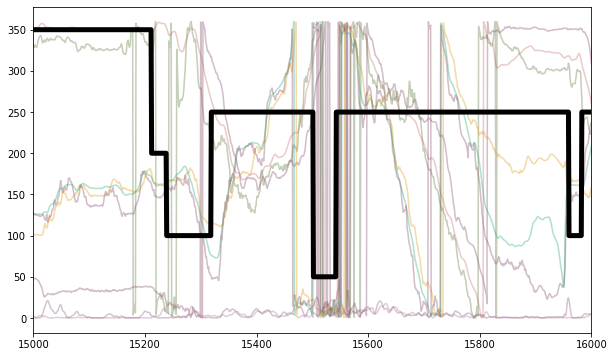

In [78]:
plt.plot(Xs, label=features_to_use, alpha=.2)
plt.plot(Ys*50, color='k', linewidth=5)
plt.xlim(15000,16000)

## Split into train and test (using cross-validation)





In [200]:
from sklearn.model_selection import StratifiedKFold, KFold

In [199]:

n_splits = 5
splitter = StratifiedKFold(n_splits=5, shuffle=False)

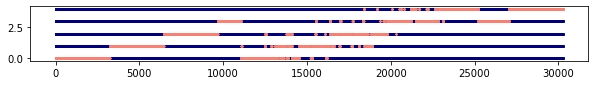

In [198]:

# splitter = KFold(n_splits=5, shuffle=False)


i = 0
plt.figure(figsize=(10,1))
for train, test in splitter.split(Xs, Ys):
    plt.scatter(train, [i]*len(train),s=1, color='navy')
    plt.scatter(test, [i]*len(test),s=1, color='salmon')
    i += 1

## Apply Logistic Regression

In [190]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [191]:
regularizer_C = 1.0
max_iter = 500

train_scores = []
test_scores = []
Ys_pred = n.zeros(Ys.shape)
for train_idxs,test_idxs in splitter.split(Xs,Ys):
    
    X_train = Xs[train_idxs]
    Y_train = Ys[train_idxs]
    
    X_test = Xs[test_idxs]
    Y_test = Ys[test_idxs]
    
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    
    clf = LogisticRegression(random_state=0, C = regularizer_C, max_iter=max_iter)
    
    clf.fit(X_train_scaled, Y_train)
    
    train_score = clf.score(X_train_scaled,Y_train)
    test_score = clf.score(X_test_scaled,Y_test)
    
    Y_pred = clf.predict(X_test_scaled)
    Ys_pred[test_idxs] = Y_pred
    
    train_scores.append(train_score)
    test_scores.append(test_score)

(0.0, 1.0)

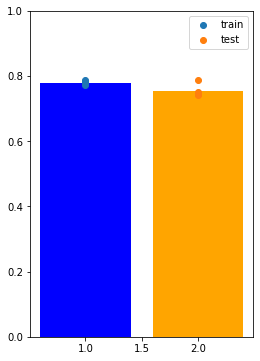

In [192]:
plt.figure(figsize=(4,6))
plt.bar([1,2],[n.mean(train_scores), n.mean(test_scores)], color=['blue','orange'])
plt.scatter([1]*n_splits, train_scores, label='train')
plt.scatter([2]*n_splits, test_scores, label='test')
plt.legend()
plt.ylim(0,1)

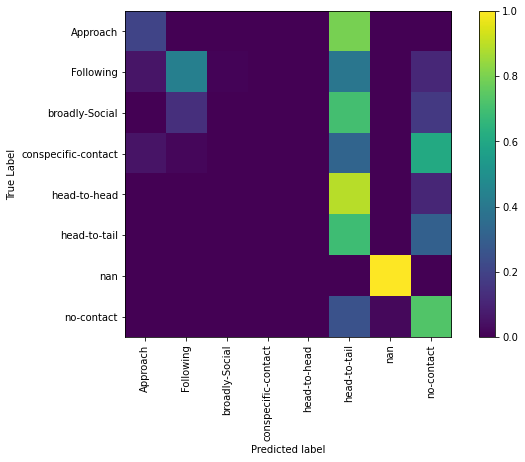

In [193]:
plt.imshow(confusion_matrix((Y_test),(Y_pred), normalize='true'), vmin=0)
# plt.xticks(unique_labels)
plt.colorbar()
plt.xlabel("Predicted label")
plt.ylabel("True Label")
plt.xticks(n.arange(len(unique_labels)),label_encoder.inverse_transform(n.arange(len(unique_labels))), rotation=90);
plt.yticks(n.arange(len(unique_labels)),label_encoder.inverse_transform(n.arange(len(unique_labels))), rotation=0);

## Apply a Support Vector Machine

In [194]:
from sklearn.svm import SVC

In [195]:
regularizer_C = 1.0
max_iter = 500

train_scores = []
test_scores = []
Ys_pred = n.zeros(Ys.shape)
for train_idxs,test_idxs in splitter.split(Xs,Ys):
    
    X_train = Xs[train_idxs]
    Y_train = Ys[train_idxs]
    
    X_test = Xs[test_idxs]
    Y_test = Ys[test_idxs]
    
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    
    clf = SVC(random_state=0, C = regularizer_C, max_iter=max_iter)
    
    clf.fit(X_train_scaled, Y_train)
    
    train_score = clf.score(X_train_scaled,Y_train)
    test_score = clf.score(X_test_scaled,Y_test)
    
    Y_pred = clf.predict(X_test_scaled)
    Ys_pred[test_idxs] = Y_pred
    
    train_scores.append(train_score)
    test_scores.append(test_score)

/home/ali/anaconda3/envs/swc-en-social/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/ali/anaconda3/envs/swc-en-social/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/ali/anaconda3/envs/swc-en-social/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/ali/anaconda3/envs/swc-en-social/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/ali/anaconda3/envs/swc-en-

(0.0, 1.0)

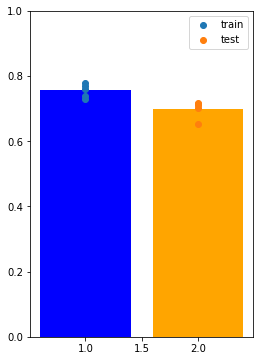

In [196]:
plt.figure(figsize=(4,6))
plt.bar([1,2],[n.mean(train_scores), n.mean(test_scores)], color=['blue','orange'])
plt.scatter([1]*n_splits, train_scores, label='train')
plt.scatter([2]*n_splits, test_scores, label='test')
plt.legend()
plt.ylim(0,1)

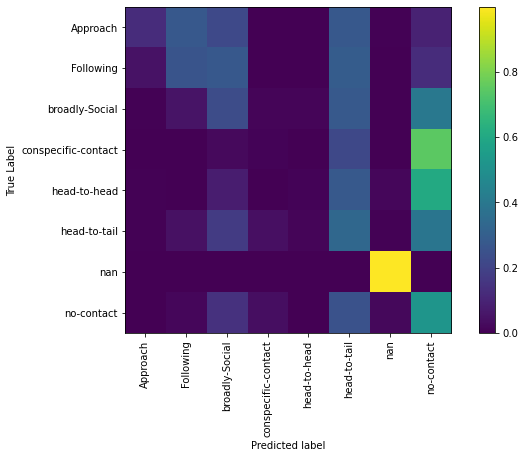

In [197]:
plt.imshow(confusion_matrix((Ys),(Ys_pred), normalize='true'), vmin=0)
# plt.xticks(unique_labels)
plt.colorbar()
plt.xlabel("Predicted label")
plt.ylabel("True Label")
plt.xticks(n.arange(len(unique_labels)),label_encoder.inverse_transform(n.arange(len(unique_labels))), rotation=90);
plt.yticks(n.arange(len(unique_labels)),label_encoder.inverse_transform(n.arange(len(unique_labels))), rotation=0);

## Ideas
- What other features could be relevant or useful to annotate between these behaviours?
- Do egocentric/allocentric coordinates matter?
- What are better ways to measure the success of the classifier? Since this metric seems to not be very informative about how it performs
- Can you classify well across videos? If you train on one and test on the next?
- Are there hyper-parameters of the algorithms that may have significant effects on the results?
- Is the quality of prediction of a class dependent on how many samples it has? Is there a way to balance this?
- How do you deal with nans (occluded points) in the data?